In [1]:
import sys
import json
from datetime import datetime
from time import time, sleep

from pymongo import MongoClient, ASCENDING
import pandas as pd

from vnpy.trader.vtObject import VtBarData, VtTickData
from vnpy.trader.app.ctaStrategy.ctaBase import (MINUTE_DB_NAME, 
                                                 DAILY_DB_NAME, 
                                                 TICK_DB_NAME)

import jqdatasdk as jq

from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting
from vnpy.trader.app.ctaStrategy.strategy.strategyBollChannel import BollChannelStrategy
from vnpy.trader.app.ctaStrategy.ctaTemplate import CtaTemplate, BarGenerator, ArrayManager

In [2]:
setting = {
    "Username": "18761689027",
    "Password": "mghy1996",
    "rb1910":"RB1910.XSGE",
    "zn1807": "ZN1807.XSGE",
    "rb0000": "RB9999.XSGE"
}

mc = MongoClient()                  # Mongo连接
dbMinute = mc[MINUTE_DB_NAME]       # 数据库
dbDaily = mc[DAILY_DB_NAME]
dbTick = mc[TICK_DB_NAME]

USERNAME = setting["Username"]
PASSWORD = setting["Password"]
jq.auth(USERNAME, PASSWORD)

FIELDS = ['open', 'high', 'low', 'close', 'volume']

auth success  - 聚宽高频因子挖掘挑战赛正式启动。快来参赛获得认证证书、正式&实习Offer、奖金等，详情查看大赛官方网页：http://t.cn/EowDwNU


In [3]:
"""
    若干用于下载数据的函数
"""

#----------------------------------------------------------------------
def generateVtBar(row, symbol):
    """生成K线"""
    bar = VtBarData()
    
    bar.symbol = symbol
    bar.vtSymbol = symbol
    bar.open = row['open']
    bar.high = row['high']
    bar.low = row['low']
    bar.close = row['close']
    bar.volume = row['volume']
    bar.datetime = row.name
    bar.date = bar.datetime.strftime("%Y%m%d")
    bar.time = bar.datetime.strftime("%H:%M:%S")
    
    return bar

#----------------------------------------------------------------------
def generateVtTick(row, symbol):
    """生成K线"""
    tick = VtTickData()
    tick.symbol = symbol
    tick.vtSymbol = symbol
    
    tick.lastPrice = row['last']
    tick.volume = row['volume']
    tick.openInterest = row['open_interest']
    tick.datetime = row.name
    tick.openPrice = row['open']
    tick.highPrice = row['high']
    tick.lowPrice = row['low']
    tick.preClosePrice = row['prev_close']
    tick.upperLimit = row['limit_up']
    tick.lowerLimit = row['limit_down']
    
    tick.bidPrice1 = row['b1']
    tick.bidPrice2 = row['b2']
    tick.bidPrice3 = row['b3']
    tick.bidPrice4 = row['b4']
    tick.bidPrice5 = row['b5']
    
    tick.bidVolume1 = row['b1_v']
    tick.bidVolume2 = row['b2_v']
    tick.bidVolume3 = row['b3_v']
    tick.bidVolume4 = row['b4_v']
    tick.bidVolume5 = row['b5_v']    
    
    tick.askPrice1 = row['a1']
    tick.askPrice2 = row['a2']
    tick.askPrice3 = row['a3']
    tick.askPrice4 = row['a4']
    tick.askPrice5 = row['a5']
    
    tick.askVolume1 = row['a1_v']
    tick.askVolume2 = row['a2_v']
    tick.askVolume3 = row['a3_v']
    tick.askVolume4 = row['a4_v']
    tick.askVolume5 = row['a5_v']        
    
    return tick

#----------------------------------------------------------------------
def downloadMinuteBarBySymbol(symbol, startdate, enddate):
    """下载某一合约的分钟线数据"""
    start = time()
    cl = dbMinute[symbol]
    cl.create_index([('datetime', ASCENDING)], unique=True)         # 添加索引
    
    df = jq.get_price(setting[symbol], start_date=startdate, end_date=enddate, frequency='1m', fields=FIELDS)
    nums = 0
    for ix, row in df.iterrows():
        nums += 1
        bar = generateVtBar(row, symbol)
        d = bar.__dict__
        flt = {'datetime': bar.datetime}
        cl.replace_one(flt, d, True)            

    end = time()
    cost = (end - start) * 1000

    print(u'合约%s的分钟K线数据下载完成%s - %s，耗时%s毫秒' %(symbol, df.index[0], df.index[-1], cost))
    print(jq.get_query_count())
    print(nums)

#----------------------------------------------------------------------
def downloadDailyBarBySymbol(symbol, startdate, enddate):
    """下载某一合约日线数据"""
    start = time()
    cl = dbDaily[symbol]
    cl.create_index([('datetime', ASCENDING)], unique=True)         # 添加索引
    
    df = jq.get_price(setting[symbol], start_date=startdate, end_date=enddate, frequency='1d', fields=FIELDS)
    
    for ix, row in df.iterrows():
        bar = generateVtBar(row, symbol)
        d = bar.__dict__
        flt = {'datetime': bar.datetime}
        cl.replace_one(flt, d, True)            

    end = time()
    cost = (end - start) * 1000

    print(u'合约%s的日K线数据下载完成%s - %s，耗时%s毫秒' %(symbol, df.index[0], df.index[-1], cost))
    print(jq.get_query_count())
    
#----------------------------------------------------------------------
def downloadTickBySymbol(symbol, date):
    """下载某一合约Tick线数据"""
    start = time()

    cl = dbTick[symbol]
    cl.create_index([('datetime', ASCENDING)], unique=True)         # 添加索引
    
    df = jq.get_price(setting[symbol], 
                      frequency='tick', 
                      start_date=date, 
                      end_date=date)
    
    for ix, row in df.iterrows():
        tick = generateVtTick(row, symbol)
        d = tick.__dict__
        flt = {'datetime': tick.datetime}
        cl.replace_one(flt, d, True)            

    end = time()
    cost = (end - start) * 1000

    print(u'合约%sTick数据下载完成%s - %s，耗时%s毫秒' %(symbol, df.index[0], df.index[-1], cost))

In [4]:
# 下载所需数据

downloadMinuteBarBySymbol('rb0000', '2018-1-1', '2018-5-1')

合约rb0000的分钟K线数据下载完成2018-01-02 09:01:00 - 2018-04-27 15:00:00，耗时17475.046396255493毫秒
{'total': 1000000, 'spare': 249242}
26205


In [5]:
# 创建回测引擎对象
engine = BacktestingEngine()

In [6]:
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase(MINUTE_DB_NAME, 'rb0000')  # 设置使用的历史数据库
engine.setStartDate('20180101')               # 设置回测用的数据起始日期

In [7]:
# 配置回测引擎参数
engine.setSlippage(1)      # 设置滑点为1跳
engine.setRate(1/10000)    # 设置手续费万1
engine.setSize(10)         # 设置合约大小 
engine.setPriceTick(1)     # 设置最小价格变动   
engine.setCapital(30000)   # 设置回测本金

In [8]:
"""
    开发自己的策略，要继承CtaTemplate类
"""

class AtrRsiStrategy(CtaTemplate):
    """结合ATR和RSI指标的一个分钟线交易策略"""
    className = 'AtrRsiStrategy'
    author = u'用Python的交易员'

    # 策略参数
    atrLength = 22          # 计算ATR指标的窗口数   
    atrMaLength = 10        # 计算ATR均线的窗口数
    rsiLength = 5           # 计算RSI的窗口数
    rsiEntry = 16           # RSI的开仓信号
    trailingPercent = 0.8   # 百分比移动止损
    initDays = 10           # 初始化数据所用的天数
    fixedSize = 1           # 每次交易的数量

    # 策略变量
    atrValue = 0                        # 最新的ATR指标数值
    atrMa = 0                           # ATR移动平均的数值
    rsiValue = 0                        # RSI指标的数值
    rsiBuy = 0                          # RSI买开阈值
    rsiSell = 0                         # RSI卖开阈值
    intraTradeHigh = 0                  # 移动止损用的持仓期内最高价
    intraTradeLow = 0                   # 移动止损用的持仓期内最低价

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'atrLength',
                 'atrMaLength',
                 'rsiLength',
                 'rsiEntry',
                 'trailingPercent']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'atrValue',
               'atrMa',
               'rsiValue',
               'rsiBuy',
               'rsiSell']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['pos',
                'intraTradeHigh',
                'intraTradeLow']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(AtrRsiStrategy, self).__init__(ctaEngine, setting)
        
        # 创建K线合成器对象
        self.bg = BarGenerator(self.onBar)
        self.am = ArrayManager()
        
        # 注意策略类中的可变对象属性（通常是list和dict等），在策略初始化时需要重新创建，
        # 否则会出现多个策略实例之间数据共享的情况，有可能导致潜在的策略逻辑错误风险，
        # 策略类中的这些可变对象属性可以选择不写，全都放在__init__下面，写主要是为了阅读
        # 策略时方便（更多是个编程习惯的选择）        

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
    
        # 初始化RSI入场阈值
        self.rsiBuy = 50 + self.rsiEntry
        self.rsiSell = 50 - self.rsiEntry

        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        self.bg.updateTick(tick)

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()

        # 保存K线数据
        am = self.am
        am.updateBar(bar)
        if not am.inited:
            return

        # 计算指标数值
        atrArray = am.atr(self.atrLength, array=True)
        self.atrValue = atrArray[-1]
        self.atrMa = atrArray[-self.atrMaLength:].mean()
        
        self.rsiValue = am.rsi(self.rsiLength)

        # 判断是否要进行交易
        
        # 当前无仓位
        if self.pos == 0:
            self.intraTradeHigh = bar.high
            self.intraTradeLow = bar.low

            # ATR数值上穿其移动平均线，说明行情短期内波动加大
            # 即处于趋势的概率较大，适合CTA开仓
            if self.atrValue > self.atrMa:
                # 使用RSI指标的趋势行情时，会在超买超卖区钝化特征，作为开仓信号
                if self.rsiValue > self.rsiBuy:
                    # 这里为了保证成交，选择超价5个整指数点下单
                    self.buy(bar.close+5, self.fixedSize)

                elif self.rsiValue < self.rsiSell:
                    self.short(bar.close-5, self.fixedSize)

        # 持有多头仓位
        elif self.pos > 0:
            # 计算多头持有期内的最高价，以及重置最低价
            self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
            self.intraTradeLow = bar.low
            
            # 计算多头移动止损
            longStop = self.intraTradeHigh * (1-self.trailingPercent/100)

            # 发出本地止损委托
            self.sell(longStop, abs(self.pos), stop=True)
            
        # 持有空头仓位
        elif self.pos < 0:
            self.intraTradeLow = min(self.intraTradeLow, bar.low)
            self.intraTradeHigh = bar.high

            shortStop = self.intraTradeLow * (1+self.trailingPercent/100)
            self.cover(shortStop, abs(self.pos), stop=True)

        # 同步数据到数据库
        self.saveSyncData()

        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [9]:
# 在引擎中创建策略对象
d = {}                                         # 策略参数配置
#engine.initStrategy(BollChannelStrategy, d)    # 创建策略对象
engine.initStrategy(AtrRsiStrategy, d)    # 创建策略对象

In [10]:
# 运行回测
engine.runBacktesting()

2019-05-11 17:32:09.528007	开始载入数据
2019-05-11 17:32:09.574884	载入完成，数据量：110195
2019-05-11 17:32:09.574884	开始回测
2019-05-11 17:32:09.620760	策略初始化完成
2019-05-11 17:32:09.620760	策略启动完成
2019-05-11 17:32:09.620760	开始回放数据
2019-05-11 17:32:14.486420	数据回放结束


2019-05-11 17:32:14.490410	计算按日统计结果
2019-05-11 17:32:14.494399	------------------------------
2019-05-11 17:32:14.494399	首个交易日：	2018-01-11
2019-05-11 17:32:14.494399	最后交易日：	2019-04-30
2019-05-11 17:32:14.494399	总交易日：	315
2019-05-11 17:32:14.494399	盈利交易日	152
2019-05-11 17:32:14.494399	亏损交易日：	163
2019-05-11 17:32:14.494399	起始资金：	30000
2019-05-11 17:32:14.494399	结束资金：	27,164.65
2019-05-11 17:32:14.494399	总收益率：	-9.45%
2019-05-11 17:32:14.495408	年化收益：	-3.78%
2019-05-11 17:32:14.495408	总盈亏：	-2,835.35
2019-05-11 17:32:14.495408	最大回撤: 	-9,196.83
2019-05-11 17:32:14.495408	百分比最大回撤: -25.73%
2019-05-11 17:32:14.495408	总手续费：	5,405.35
2019-05-11 17:32:14.495408	总滑点：	14,350
2019-05-11 17:32:14.495408	总成交金额：	54,053,520.0
2019-05-11 17:32:14.495408	总成交笔数：	1,435
2019-05-11 17:32:14.495408	日均盈亏：	-9.0
2019-05-11 17:32:14.495408	日均手续费：	17.16
2019-05-11 17:32:14.495408	日均滑点：	45.56
2019-05-11 17:32:14.495408	日均成交金额：	171,598.48
2019-05-11 17:32:14.495408	日均成交笔数：	4.56
2019-05-11 17:32:14.495408	日均收益率：	-0.02%


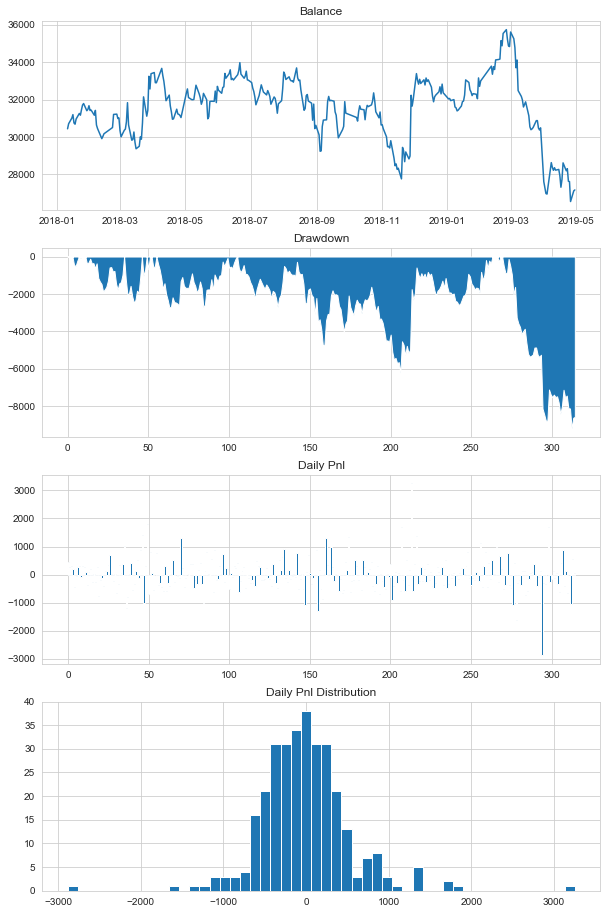

In [11]:
# 显示逐日回测结果
engine.showDailyResult()

2019-05-11 17:32:23.167626	计算回测结果
2019-05-11 17:32:23.177630	------------------------------
2019-05-11 17:32:23.177630	第一笔交易：	2018-01-15 10:11:00
2019-05-11 17:32:23.177630	最后一笔交易：	2019-04-30 14:59:00
2019-05-11 17:32:23.177630	总交易次数：	718
2019-05-11 17:32:23.177630	总盈亏：	-2,849.18
2019-05-11 17:32:23.177630	最大回撤: 	-9,116.76
2019-05-11 17:32:23.177630	平均每笔盈利：	-3.97
2019-05-11 17:32:23.177630	平均每笔滑点：	20.0
2019-05-11 17:32:23.177630	平均每笔佣金：	7.53
2019-05-11 17:32:23.177630	胜率		35.38%
2019-05-11 17:32:23.177630	盈利交易平均值	347.73
2019-05-11 17:32:23.178601	亏损交易平均值	-196.49
2019-05-11 17:32:23.178601	盈亏比：	1.77


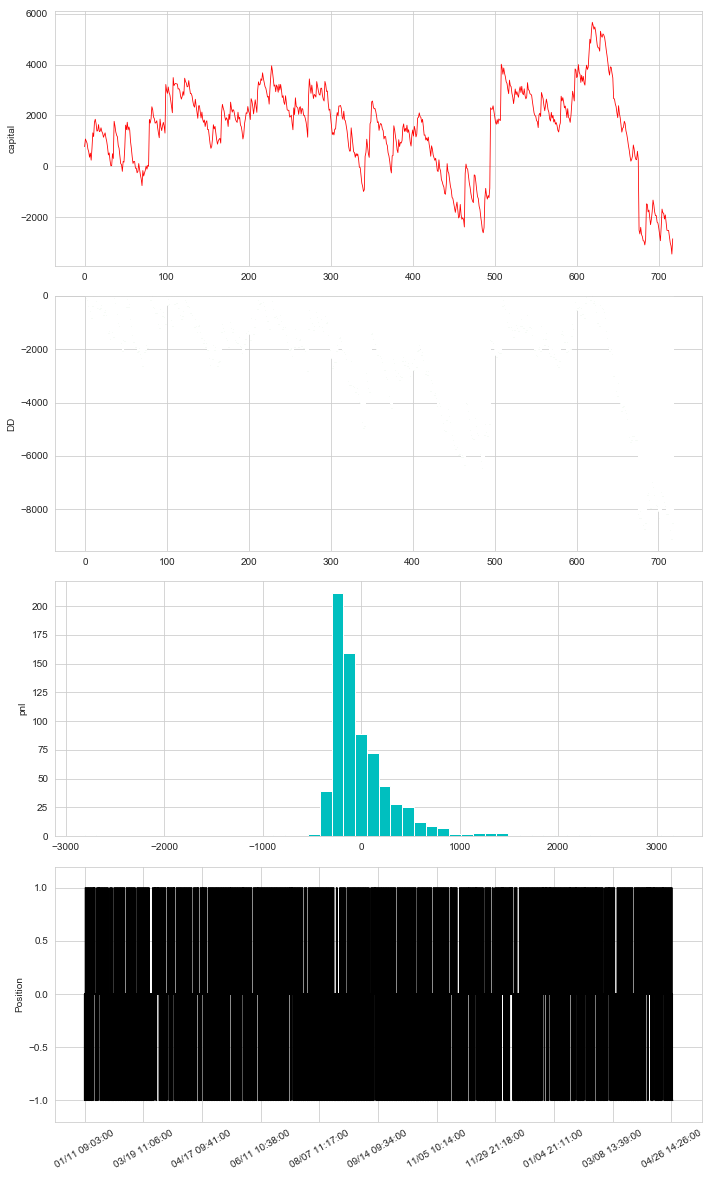

In [12]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [13]:
# 显示前10条成交记录
for i in range(10):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-01-11 09:03:00, Direction: 空, Price: 3859.0, Volume: 1
TradeID: 2, Time: 2018-01-15 10:11:00, Direction: 多, Price: 3779.0, Volume: 1
TradeID: 3, Time: 2018-01-15 10:12:00, Direction: 多, Price: 3780.0, Volume: 1
TradeID: 4, Time: 2018-01-16 14:05:00, Direction: 空, Price: 3813.0, Volume: 1
TradeID: 5, Time: 2018-01-16 14:06:00, Direction: 空, Price: 3810.0, Volume: 1
TradeID: 6, Time: 2018-01-16 22:34:00, Direction: 多, Price: 3815.0, Volume: 1
TradeID: 7, Time: 2018-01-16 22:35:00, Direction: 多, Price: 3815.0, Volume: 1
TradeID: 8, Time: 2018-01-17 14:39:00, Direction: 空, Price: 3809.0, Volume: 1
TradeID: 9, Time: 2018-01-17 14:40:00, Direction: 空, Price: 3805.0, Volume: 1
TradeID: 10, Time: 2018-01-17 14:53:00, Direction: 多, Price: 3825.0, Volume: 1
